#### Context:
The HR department wants to take some initiatives to improve employee satisfaction levels at the company. If able to predict employees likely to quit, it might be possible to identify factors that contribute to their leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company. 

Problem statement: What’s likely to make the employee leave the company?

#### Goal: 
Analyze the data collected by the HR department and to build a regression/machine learning model that predicts whether or not an employee will leave the company.

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
#from xgboost import XGBClassifier
#from xgboost import XGBRegressor
#from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

In [2]:
df0 = pd.read_csv("HR_comma_sep.csv")

df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Data Exploration (Initial EDA and data cleaning)

In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [5]:
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [6]:
# standardise to snake_case

df0 = df0.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [7]:
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [8]:
df0.duplicated().sum()

3008

In [9]:
# Inspect rows containing duplicates, drop if logical 

df0[df0.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


In [10]:
df1 = df0.drop_duplicates(keep='first')

df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Check for outliers in 'tenure' using boxplots

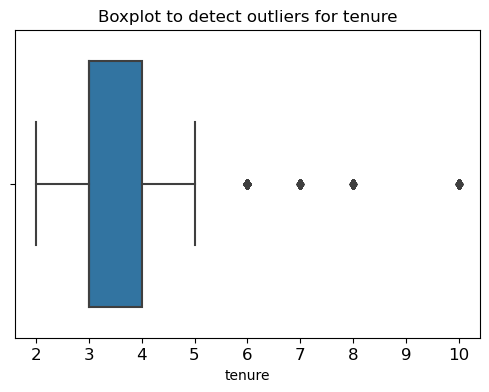

In [11]:
plt.figure(figsize=(6,4))
plt.title('Boxplot to detect outliers for tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df1['tenure'])
plt.show()

In [12]:
percentile25 = df1['tenure'].quantile(0.25)
percentile75 = df1['tenure'].quantile(0.75)
iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]
print("Number of rows in the data containing outliers in `tenure`:", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in `tenure`: 824


### Data visualisations

Determine how many and what percentage of employees left.

In [13]:
print(df1['left'].value_counts())
print()
print(df1['left'].value_counts(normalize=True))

0    10000
1     1991
Name: left, dtype: int64

0    0.833959
1    0.166041
Name: left, dtype: float64


#### Visualisation 1. Stacked boxplot: compare the distributions of `average_monthly_hours` for stayed vs left
#### Visualisation 2. Stacked histogram: compare the distribution of `number_project` for stayed vs left

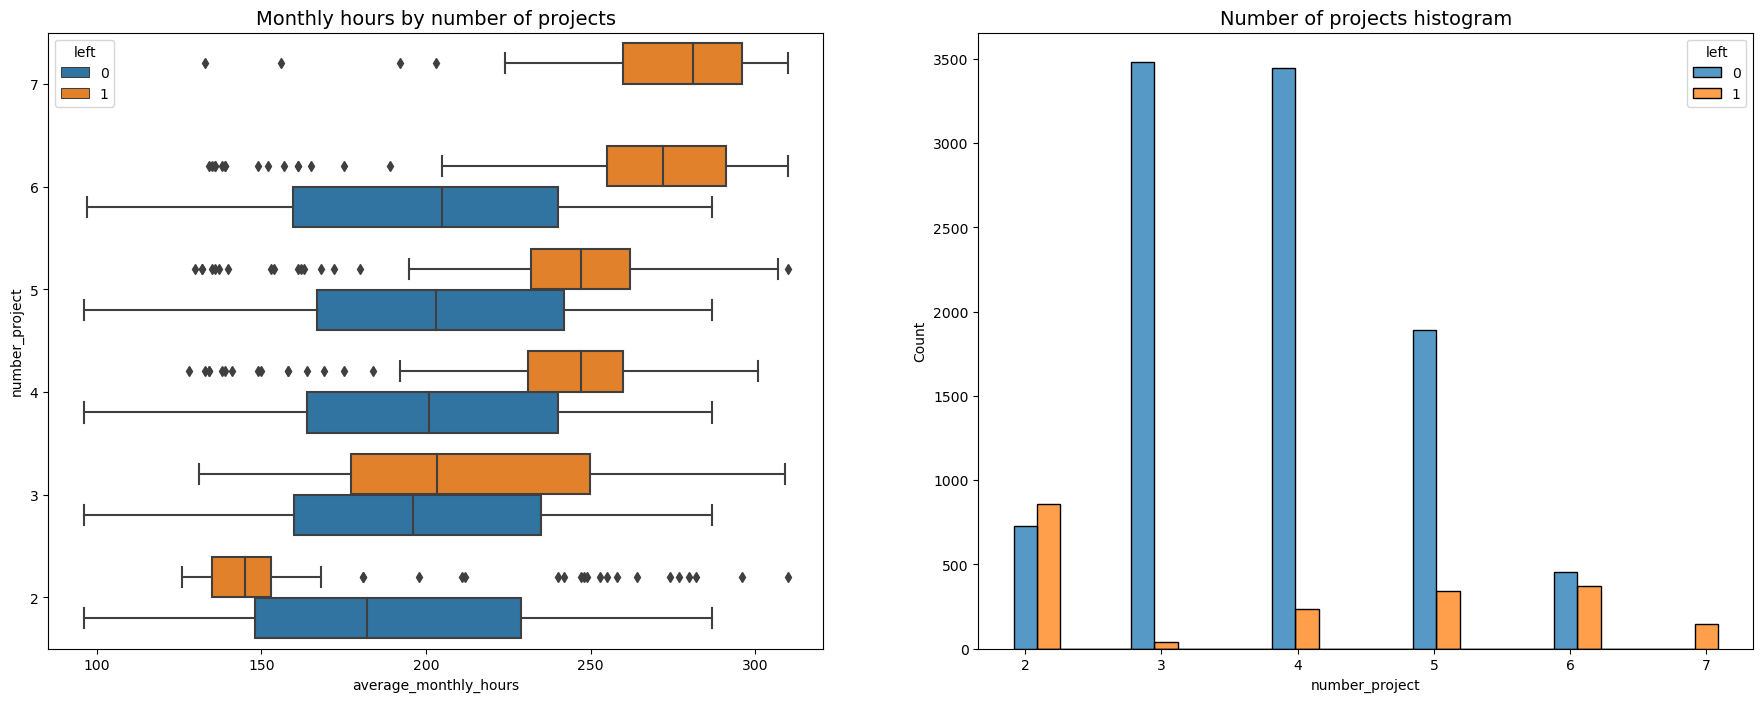

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# 1. Boxplot
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

# 2. Histogram
tenure_stay = df1[df1['left']==0]['number_project']
tenure_left = df1[df1['left']==1]['number_project']
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

plt.show()

A natural assumption would be that people who work on more projects would also work longer hours. This appears to be the case here, with the mean hours of each group (stayed and left) increasing with number of projects worked. However, a few things stand out from this plot:

1. There are two groups of employees who left the company: (A) those who worked considerably less than their peers with the same number of projects, and (B) those who worked much more. Of those in group A, it's possible that they were fired. It's also possible that this group includes employees who had already given their notice and were assigned fewer hours because they were already on their way out the door. For those in group B, it's reasonable to infer that they probably quit. The people in group B likely contributed a lot to the projects they worked in; they might have been the largest contributors to their projects. 

2. Everyone with seven projects left the company, and the interquartile ranges of this group and those who left with six projects was ~255&ndash;295 hours/month&mdash;much more than any other group. Thus the next step is to confirm that all employees with seven projects left.

3. The optimal number of projects for employees to work on seems to be 3&ndash;4. The ratio of left/stayed is very small for these cohorts.

4. If you assume a work week of 40 hours and two weeks of vacation per year, then the average number of working hours per month of employees working Monday&ndash;Friday `= 50 weeks * 40 hours per week / 12 months = 166.67 hours per month`. This means that, aside from the employees who worked on two projects, every group&mdash;even those who didn't leave the company&mdash;worked considerably more hours than this. It implies that employees here are overworked.

In [15]:
df1[df1['number_project']==7]['left'].value_counts()

1    145
Name: left, dtype: int64

This confirms that all employees with 7 projects did leave.
Next, examine the average monthly hours versus the satisfaction levels.

#### Visualisation 3. Scatterplot: compare the distributions of `average_monthly_hours` vs `satisfaction level` for stayed vs left

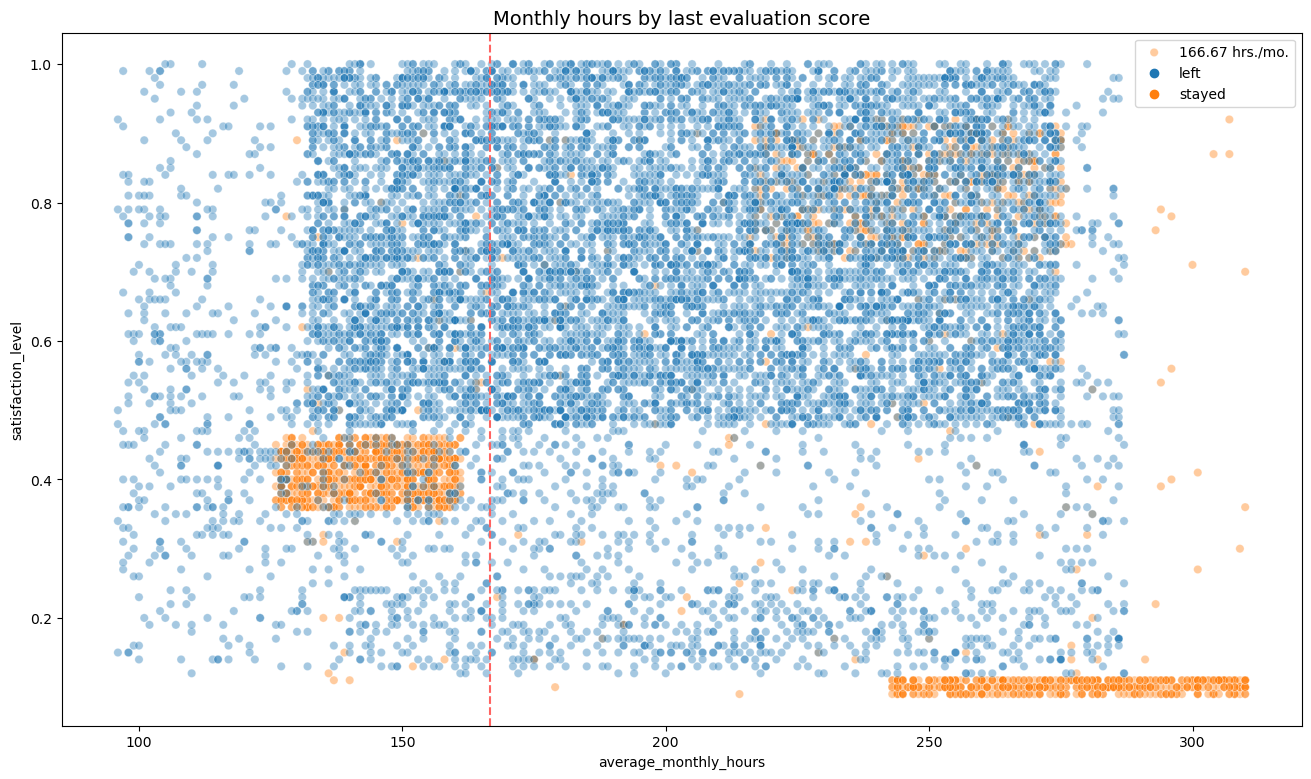

In [18]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

The following observations can be made from the scatterplot above:
- The scatterplot indicates two groups of employees who left: overworked employees who performed very well and employees who worked slightly under the nominal monthly average of 166.67 hours with lower evaluation scores. 
- There seems to be a correlation between hours worked and evaluation score. 
- There isn't a high percentage of employees in the upper left quadrant of this plot; but working long hours doesn't guarantee a good evaluation score.
- Most of the employees in this company work well over 167 hours per month.


Given these parameters: satisfaction_level, last_evaluation, number_project, average_monthly_hours, tenure, work_accident, left, promotion_last_5years, department, salary. Next step is to examine whether employees who worked very long hours were promoted in the last five years.

#### Visualisation 4. Scatterplot: compare the distributions of `average_monthly_hours` vs `promotion_last_5years` for stayed vs left

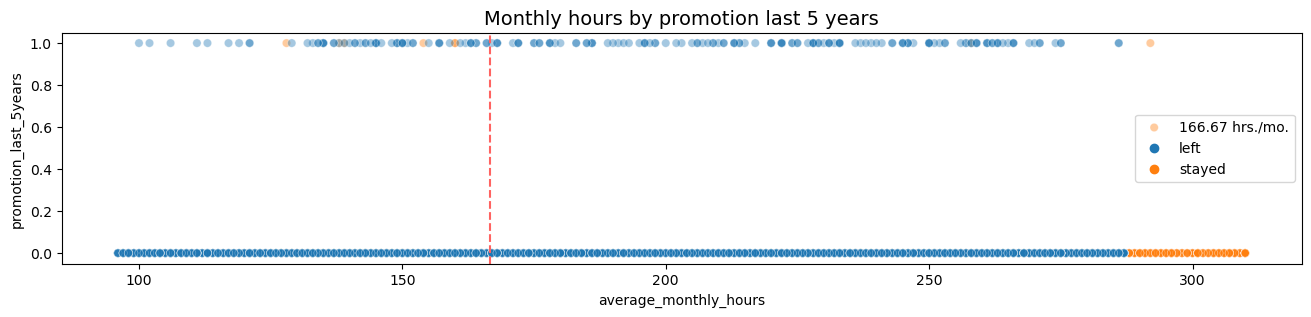

In [20]:
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

The plot above shows the following:
- very few employees who were promoted in the last five years left
- very few employees who worked the most hours were promoted
- all of the employees who left were working the longest hours  

Next, inspect how the employees who left are distributed across departments.

In [21]:
df1["department"].value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64

#### Visualisation 5. Stacked histogram: compare the distributions of departments for stayed vs left

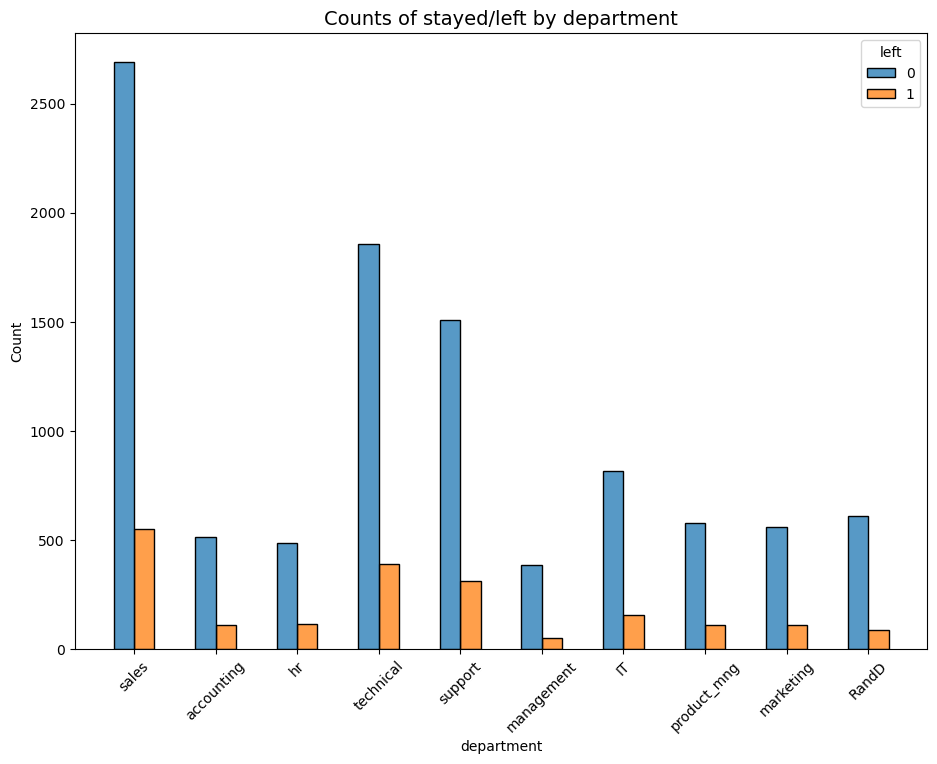

In [22]:
plt.figure(figsize=(11,8))
sns.histplot(data=df1, x='department', hue='left', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation='45')
plt.title('Counts of stayed/left by department', fontsize=14);

#### Visualisation 6. Correlation Heatmap: compare the distributions of departments for stayed vs left

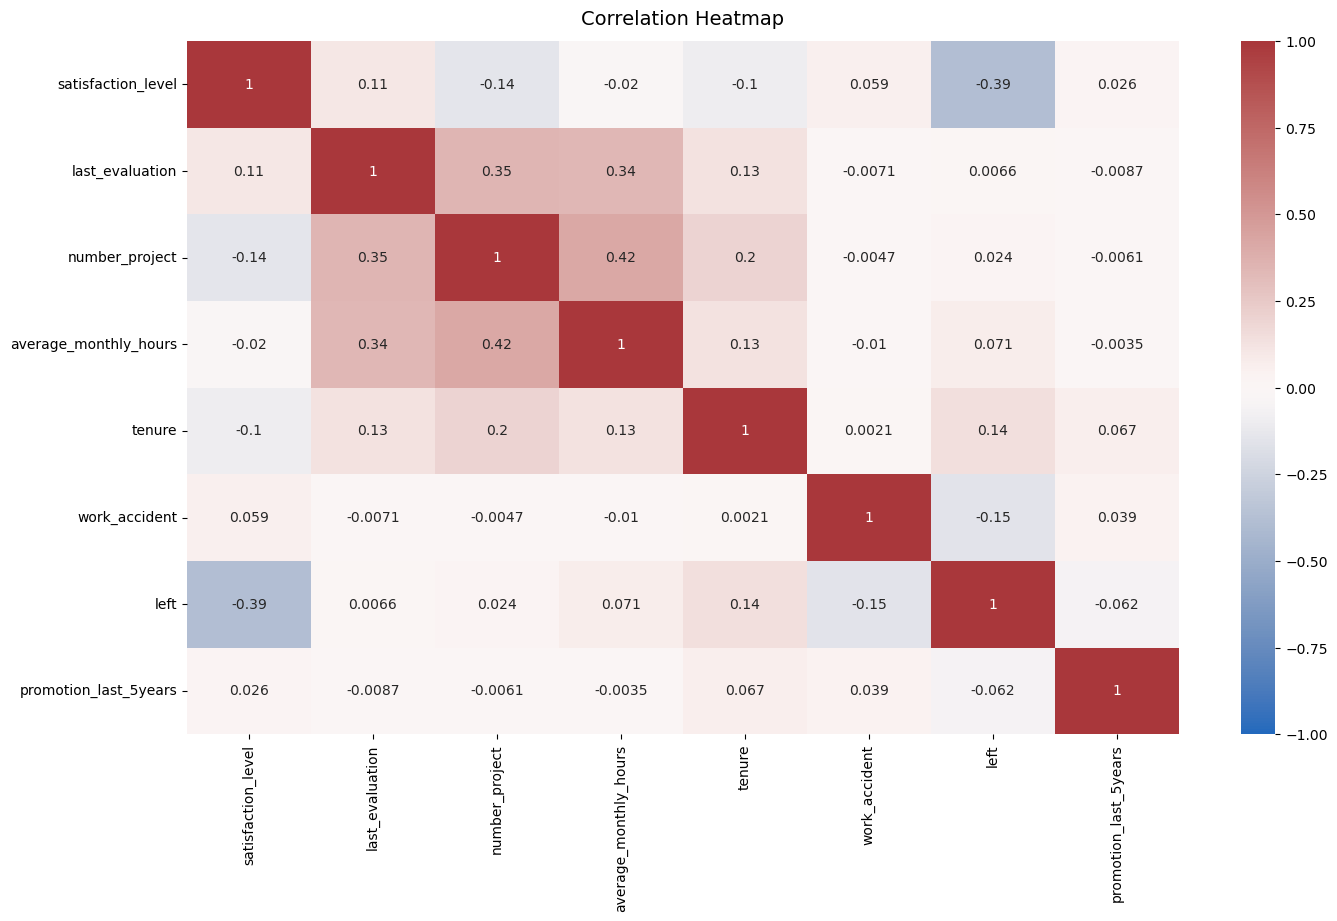

In [23]:
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df0.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

#### Analysis

The correlation heatmap confirms that the number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their satisfaction level.

#### Insights

It appears that employees are leaving the company as a result of poor management. Leaving is tied to longer working hours, many projects, and generally lower satisfaction levels. It can be ungratifying to work long hours and not receive promotions or good evaluation scores. There's a sizeable group of employees at this company who are probably burned out. It also appears that if an employee has spent more than six years at the company, they tend not to leave. 

## Data Modelling

Predict whether an employee leaves the company (Classification Task - use binary logistic regression)

In [30]:
# Encode non-numeric variables ('salary', 'department') before splitting data

# 'salary' is ordinal, convert levels to numbers
# 'department' can just dummy

df_enc = df1.copy()

df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

df_enc = pd.get_dummies(df_enc, drop_first=False)
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


### Create a heatmap to visualise how correlated variables are

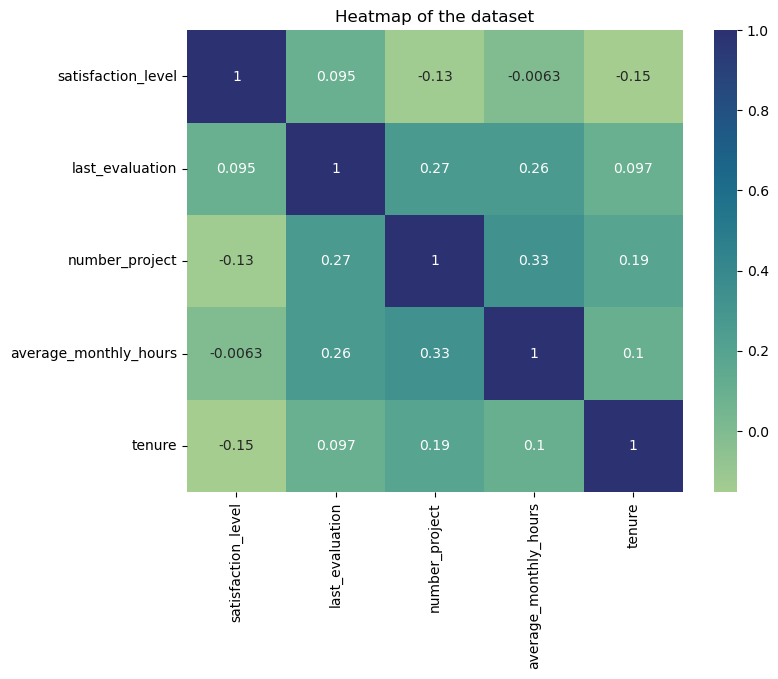

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

### Stacked bart plot to visualise number of employees across department, comparing left vs stayed

In [2]:
pd.crosstab(df1['department'], df1['left']).plot(kind ='bar',color='mr')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show() # In the legend, 0 (purple color) represents employees who stayed, 1 (red color) represents employees who left

NameError: name 'pd' is not defined

In [33]:
# Remove outliers in `tenure` since logistic regression is sensitive to outliers
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]
df_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [34]:
# Isolate the outcome variable (to be predicted)
y = df_logreg['left']
y.head() 

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [35]:
# Feature selection
X = df_logreg.drop('left', axis=1)
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,0,0,0,0,0,0,0,0,0,1,0,0


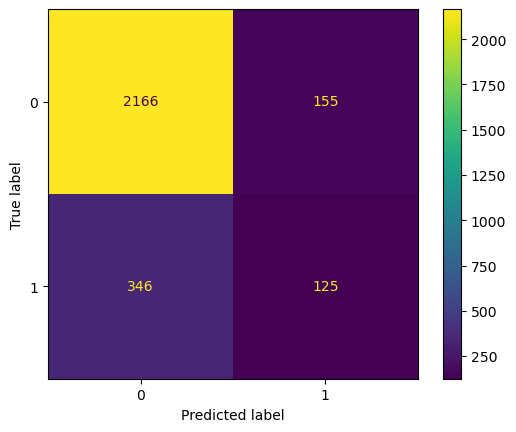

In [38]:
# Construct and fit model to training data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)


# Test model to make predictions on test set, and visualise results.
y_pred = log_clf.predict(X_test)

log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

log_disp.plot(values_format='')

plt.show()

- True negatives: The number of people who did not leave that the model accurately predicted did not leave.

- False positives: The number of people who did not leave the model inaccurately predicted as leaving.

- False negatives: The number of people who left that the model inaccurately predicted did not leave

- True positives: The number of people who left the model accurately predicted as leaving

#### Evaluate the performance of the logistic regression model

Use standards of measures including: precision, recall, f1-score, accuracy metrics, class balance (value counts in the `left` col)

In [39]:
df_logreg['left'].value_counts(normalize=True)

0    0.831468
1    0.168532
Name: left, dtype: float64

An approximate 83%-17% split is not too imbalanced (else need to resample the data). In this case, can use this data without modifying the class balance and continue evaluating the model.

In [40]:
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.45      0.27      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792



#### Analysis: 
The classification report above shows that the logistic regression model achieved a precision of 79%, recall of 82%, f1-score of 80% (all weighted averages), and accuracy of 82%. However, if it's most important to predict employees who leave, then the scores are significantly lower.

## Results and Evaluation

The logistic regression model achieved precision of 80%, recall of 83%, f1-score of 80% (all weighted averages), and accuracy of 83%, on the test set.

The models and the feature importances extracted from the models confirm that employees at the company are overworked.
To retain employees, the following recommendations could be presented to the stakeholders:
- Cap the number of projects that employees can work on.
- Consider promoting employees who have been with the company for atleast four years, or conduct further investigation about why four-year tenured employees are so dissatisfied.
- Either reward employees for working longer hours, or don't require them to do so.
- If employees aren't familiar with the company's overtime pay policies, inform them about this. If the expectations around workload and time off aren't explicit, make them clear.
- Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts.
- High evaluation scores should not be reserved for employees who work 200+ hours per month. Consider a proportionate scale for rewarding employees who contribute more/put in more effort.